In [1]:
from __future__ import print_function

# to be able to see plots
%matplotlib inline  
import matplotlib.pyplot as plt

import numpy as np

import sys
sys.path.append("../tools")

from tools import collage

# just to use a fraction of GPU memory 
# This is not needed on dedicated machines.
# Allows you to share the GPU.
# This is specific to tensorflow.
gpu_memory_usage=0.7 
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_usage
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [68]:
from collections import defaultdict
import os
import cv2

class PairDataset(object):
    def __init__(self, listFile, path='/mnt/data/MegafaceIdentities_VGG/', resolution=64):
        self.resolution = resolution
        images = defaultdict(list)
        with open(listFile, 'r') as f:
            for line in f:
                line = line.strip()
                d = os.path.dirname(line)
                images[d].append(line)
        self.images = []
        print('Loading {} identities.'.format(len(images)))
        for i in images:
            tmp = np.zeros((len(images[i]), resolution, resolution, 3), dtype=np.uint8)
            for id, name in enumerate(images[i]):
                imagePath = os.path.join(path, name)
                img = cv2.imread(imagePath, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (resolution, resolution))
                tmp[id] = img
            self.images.append(tmp)
        print('DONE')

    def create_positive_pairs(self, count):
        selectedId = np.random.choice(len(self.images), count)
        img1 = []
        img2 = []
        
        for i in selectedId:
            pair = np.random.choice(len(self.images[i]), 2, replace=False)
            img1.append(self.images[i][pair[0]])
            img2.append(self.images[i][pair[1]])
            
        img1 = np.stack(img1).astype(np.float32) / 256.0
        img2 = np.stack(img2).astype(np.float32) / 256.0
        
        return img1, img2

    def create_negative_pairs(self, count):

        img1 = []
        img2 = []
        
        for i in range(count):
            pair = np.random.choice(len(self.images), 2, replace=False)
            imgId1 = np.random.choice(len(self.images[pair[0]]), 1)
            imgId2 = np.random.choice(len(self.images[pair[1]]), 1)
            img1.append(self.images[pair[0]][imgId1[0]])
            img2.append(self.images[pair[1]][imgId2[0]])
        
        img1 = np.stack(img1).astype(np.float32) / 256.0
        img2 = np.stack(img2).astype(np.float32) / 256.0

        return img1, img2


In [71]:
dataTrn = PairDataset('faces.trn')

Loading 1270 identities.
DONE


In [69]:
dataTst = PairDataset('faces.tst')

Loading 140 identities.
DONE


(256, 256, 3)


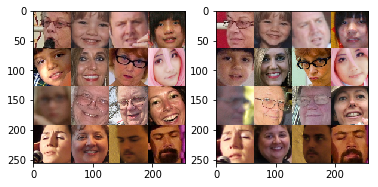

(16, 64, 64, 3) (16, 64, 64, 3)
(256, 256, 3)


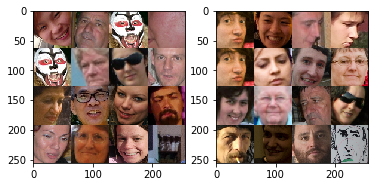

In [70]:
img1, img2 = dataTst.create_positive_pairs(16)
plt.subplot(1, 2, 1)
img = collage(img1)
print(img.shape)
plt.imshow(img[:,:,::-1])
plt.subplot(1, 2, 2)
img = collage(img2)
plt.imshow(img[:,:,::-1])
plt.show()


img1, img2 = dataTst.create_negative_pairs(16)
print(img1.shape, img2.shape)
plt.subplot(1, 2, 1)
img = collage(img1)
print(img.shape)
plt.imshow(img[:,:,::-1])
plt.subplot(1, 2, 2)
img = collage(img2)
plt.imshow(img[:,:,::-1])
plt.show()


In [104]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


def l2Norm(x):
    return  K.l2_normalize(x, axis=-1)

In [105]:
from keras.layers import Input, Reshape, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Conv2D, MaxPooling2D, PReLU, UpSampling2D
from keras.layers import Concatenate
from keras.models import Model
from keras import regularizers

from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

def build_VGG_Bnorm_block(net, channels, layers, prefix):
    for i in range(layers):
        net = Conv2D(channels, 3, padding='same',
                    name='{}.{}'.format(prefix, i))(net)
        net = BatchNormalization()(net)
        net = PReLU()(net)
    net = MaxPooling2D(2, 2, padding="same")(net)
    return net

def build_VGG_Bnorm(input_data, block_channels=[16,32,64], block_layers=[2,2,2], fcChannels=[256,256], p_drop=0.4):
    net = input_data
    for i, (cCount, lCount) in enumerate(zip(block_channels, block_layers)):
        net = build_VGG_Bnorm_block(net, cCount, lCount, 'conv{}'.format(i))
        net = Dropout(rate=0.25)(net)
        
    net = Flatten()(net)
    
    for i, cCount in enumerate(fcChannels):
        net = Dense(cCount, name='fc{}'.format(i))(net)
        net = BatchNormalization()(net)
        net = PReLU()(net)

        net = Dropout(rate=p_drop)(net)
    
    net = Dense(128, name='embed')(net)

    net = Lambda(l2Norm, output_shape=[128])(net)    

    return net

In [106]:
from keras import optimizers
from keras.models import Model
from keras import losses
from keras import metrics


# network definition
input_shape=img1.shape[1:] 
input_data = Input(shape=input_shape)
base_network = build_VGG_Bnorm(input_data, block_channels=[16,32,64], block_layers=[2,2,2], fcChannels=[512,128], 
                p_drop=0.4)

base_network = Model(input_data, base_network)
base_network.summary()

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

net_a = base_network(input_a)
net_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([net_a, net_b])

model = Model([input_a, input_b], distance)

# train
opt = optimizers.Adam()
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv0.0 (Conv2D)             (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_89 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
p_re_lu_89 (PReLU)           (None, 64, 64, 16)        65536     
_________________________________________________________________
conv0.1 (Conv2D)             (None, 64, 64, 16)        2320      
_________________________________________________________________
batch_normalization_90 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
p_re_lu_90 (PReLU)           (None, 64, 64, 16)        65536     
__________

In [107]:
tstPairCount = 500
img1a, img2a = dataTst.create_positive_pairs(tstPairCount)
img1b, img2b = dataTst.create_negative_pairs(tstPairCount)

valImg1 = np.concatenate([img1a, img1b])
valImg2 = np.concatenate([img2a, img2b])
vallabels = np.zeros(valImg1.shape[0], dtype=np.float32)
vallabels[:img1a.shape[0]] = 1.0



In [ ]:
for i in range(1000):
    trnPairCount = 5000
    img1a, img2a = dataTrn.create_positive_pairs(trnPairCount)
    img1b, img2b = dataTrn.create_negative_pairs(trnPairCount)

    trnImg1 = np.concatenate([img1a, img1b])
    trnImg2 = np.concatenate([img2a, img2b])
    trnLabels = np.zeros(trnImg1.shape[0], dtype=np.float32)
    trnLabels[:img1a.shape[0]] = 1.0
    
    model.fit(x=[trnImg1, trnImg2], y=trnLabels, batch_size=32, epochs=i+1, validation_data=([valImg1, valImg2], vallabels), shuffle=True, initial_epoch=i)

Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 17s 2ms/step - loss: 0.2543 - accuracy: 0.6088 - val_loss: 0.2284 - val_accuracy: 0.6350
Train on 10000 samples, validate on 1000 samples
Epoch 2/2
10000/10000 [==============================] - 12s 1ms/step - loss: 0.2044 - accuracy: 0.6953 - val_loss: 0.1857 - val_accuracy: 0.7160
Train on 10000 samples, validate on 1000 samples
Epoch 3/3
10000/10000 [==============================] - 12s 1ms/step - loss: 0.1888 - accuracy: 0.7260 - val_loss: 0.1774 - val_accuracy: 0.7380
Train on 10000 samples, validate on 1000 samples
Epoch 4/4
 4000/10000 [===========>..................] - ETA: 7s - loss: 0.1847 - accuracy: 0.7398

In [ ]:
for i in ra
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

# Create model

In [ ]:


input_data = Input(shape=(trnData.shape[1:]), name='data')
net = build_VGG_Bnorm(input_data, block_channels=[32,64,128], block_layers=[4,5,6], fcChannels=[1024,1024,512,512,320,320], 
                p_drop=0.4)
model = Model(inputs=[input_data], outputs=[net])

print('Model')
model.summary()

model.compile(
    loss=losses.categorical_crossentropy, 
    optimizer=optimizers.Adam(lr=0.001), 
    metrics=[metrics.categorical_accuracy])
